# Training a simple classifier on CIFAR-10
* We will do the following steps in order:
    1. Load and normalizing the CIFAR10 training and test datasets using torchvision
    2. Define a Convolutional Neural Network
    3. Define a loss function
    4. Train the network on the training data
    5. Test the network on the test data

### Load and normalizing the CIFAR10 training and test datasets using torchvision

In [1]:
# Loading and normalizing CIFAR-10
import torch
!pip install torchvision
import torchvision
import torchvision.transforms as transforms

In [2]:
### implement 
### load dataset and define dataloader 
#torchvision.datasets.CIFAR10(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
##load dataset
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), #0~1
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] # -1 ~1
    # resize, augmentation 
)
train_dataset = torchvision.datasets.CIFAR10(
    root = "./data", train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.CIFAR10(
    root = "./data", train = False, transform = transform, download = True)

## load dataloader
batch_size = 16
trainloader = torch.utils.data.DataLoader(
    train_dataset,  batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(
    test_dataset,  batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


torch.Size([16, 3, 32, 32])
tensor([3, 4, 6, 1, 3, 6, 0, 6, 1, 9, 8, 3, 4, 1, 2, 5])


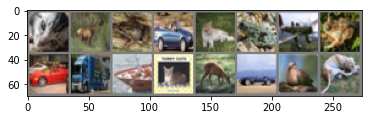

  cat  deer  frog   car   cat  frog plane  frog   car truck  ship   cat  deer   car  bird   dog


In [3]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# print(images.shape)
# print(labels.shape)
images, labels = dataiter.next()
print(images.shape)
print(labels)
# show images
# print(torchvision.utils.make_grid(images).shape)
imshow(torchvision.utils.make_grid(images))

# print labels
# print("_".join(["1", "2", "3"]))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Define a Convolutional Neural Network
* Network Model
    1. Convolution - input channel: 3, output channel: 6, kernel_size: 5
    2. Maxpoling   - size: 2, stride: 2
    3. Convolution - input channel: 6, output channel: 16, kernel_size: 5
    4. Maxpoling   - size: 2, stride: 2
    5. Fully connected layer - out_channel: 120
    6. Fully connected layer - out_channel: 84
    7. Fully connected layer - out_channel: 10
    
* Note: Apply Rectified Linear Unit(ReLU) for each layer output except last one

In [18]:
# Define a Convolutional Neural Network

import torch.nn as nn
import torch.nn.functional as F

### conv: torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
### maxpooling . torch.nn.MaxPool2d(kernel_size, stride=None)
### fc: torch.nn.linear(in_features, out_features)

### implement classification model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## add necessary layers
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 6, kernel_size = 5) #stride 1, padding 0
        self.pool1 = nn.MaxPool2d(kernel_size =2 , stride = 2)
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size =2 , stride = 2)
        self.fc1 = nn.Linear(in_features = 16 * 5 * 5, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)
        self.fc3 = nn.Linear(in_features = 84, out_features = 10)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        # x [batch, 3, 32, 32]  
        x = self.activation(self.conv1(x))
        x = self.pool1(x) # [batch, 6, 14, 14] # (14 -5 + 0)/ 1 + 1
        x = self.conv2(x) # [batch, 16, 10, 10 ]
        x = self.activation(x)
        x = self.pool2(x) # [ batch, 16, 5, 5]
        
        ##fc layer forward
        x = x.view(-1, 16*5*5) # [batch, 16*5*5]
        x = self.activation(self.fc1(x)) # [batch, 120]
        x = self.activation(self.fc2(x)) # [batch, 84]
        x = self.fc3(x) # [batch, 10]
        
        return x
net = Net()
device = "cuda"
net = net.to(device)

In [24]:
# # for debug
# net_debug = Net()
# input = torch.randn(4, 3, 32, 32)
# output = net_debug(input)
# print(output.shape)

### Define a Loss function and optimizer
* Use Classification Cross-Entropy loss
* Use SGD with learning rate 0.0001 and momentum 0.9

In [29]:
import torch.optim as optim

### implement
### define a loss and optimizer
criterion = nn.CrossEntropyLoss() ## softmax 까지 구현되어있음. 
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)



### Train the network on the training data

In [30]:
### Train the network
print('Start Training ')
net.train() #dropout, batchnorm
## train loop
epochs = 5
for epoch in range(epochs):
    for i, data in enumerate(trainloader):
#         import pdb; pdb.set_trace()
        inputs, labels = data # inputs shape [8, 3, 32, 32] labels: [8]
        inputs, labels = inputs.cuda(), labels.cuda()
        
        ## optimizer zero grad
        optimizer.zero_grad() # reset gradient to 0 
        
        # forward
        output = net(inputs) # output shape: [8, 10]
        # compute loss
        loss = criterion(output, labels) # first argument: prediction, 2nd: gt(labels)
        # backward
        loss.backward() ## compute gradient 
        ## model update
        optimizer.step() ## update model using the gradient
        
        if i % 500 == 499:
            print("epoch: {}, iter: {}, loss: {}".format(epoch+1, i+1, loss))
        
print('Finished Training')

Start Training 
epoch: 1, iter: 500, loss: 2.1401124000549316
epoch: 1, iter: 1000, loss: 1.79119074344635
epoch: 1, iter: 1500, loss: 1.610810399055481
epoch: 1, iter: 2000, loss: 1.2648409605026245
epoch: 1, iter: 2500, loss: 1.9464623928070068
epoch: 1, iter: 3000, loss: 1.3607261180877686
epoch: 1, iter: 3500, loss: 2.0802061557769775
epoch: 1, iter: 4000, loss: 2.021789073944092
epoch: 1, iter: 4500, loss: 1.6371041536331177
epoch: 1, iter: 5000, loss: 1.7502708435058594
epoch: 1, iter: 5500, loss: 0.7899951934814453
epoch: 1, iter: 6000, loss: 1.3716537952423096
epoch: 2, iter: 500, loss: 1.5780954360961914
epoch: 2, iter: 1000, loss: 0.8602343201637268
epoch: 2, iter: 1500, loss: 1.784022569656372
epoch: 2, iter: 2000, loss: 1.4683911800384521
epoch: 2, iter: 2500, loss: 1.4703055620193481
epoch: 2, iter: 3000, loss: 1.387380599975586
epoch: 2, iter: 3500, loss: 1.5145845413208008
epoch: 2, iter: 4000, loss: 0.9949485659599304
epoch: 2, iter: 4500, loss: 1.2895816564559937
epoch

### Test the network on the test data

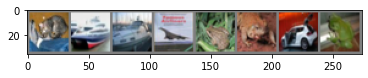

GrondTruth:    cat  ship  ship plane  frog  frog   car  frog


In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [32]:
net.eval() # make model in inference 
images = images.cuda()
outputs = net(images) # [8, 10]
_, predicted = torch.max(outputs, 1)
print(predicted)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size))) 


tensor([3, 8, 8, 8, 6, 6, 1, 6], device='cuda:0')
Predicted:    cat  ship  ship  ship  frog  frog   car  frog


In [34]:
# Let us look at how the network performs on the whole dataset

correct = 0
total = 0

### implement test loop
net.eval()
with torch.no_grad():
    for i, data in enumerate(testloader):
        inputs, labels = data # inputs shape [8, 3, 32, 32] labels: [8]
        inputs, labels = inputs.cuda(), labels.cuda()
        output = net(inputs) # output [8, 10]
        _, predicted_idx =torch.max(output, dim = 1)
        total += labels.size(0) # 8 
#         import pdb; pdb.set_trace()
        correct += (predicted_idx == labels).sum()
         
    
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size): # 8
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 80 %
Accuracy of  bird : 50 %
Accuracy of   cat : 18 %
Accuracy of  deer : 55 %
Accuracy of   dog : 65 %
Accuracy of  frog : 72 %
Accuracy of horse : 63 %
Accuracy of  ship : 76 %
Accuracy of truck : 53 %
